# Notebook 02 — Meteostat Exploration

## Rôle de la météo dans F1PA

La météo est utilisée **exclusivement comme variable explicative contextuelle**, afin d’affiner la prédiction du temps au tour.

Elle n’est :
- ni une cible,
- ni une donnée décisionnelle directe,
mais un facteur externe influençant la performance (adhérence, aérodynamique, pneus, moteur).

## Objectifs de ce notebook

L’objectif de ce notebook est de :

- comprendre la structure des données météo proposées par **Meteostat**,
- identifier les variables pertinentes pour la prédiction du temps au tour,
- analyser la granularité temporelle disponible,
- évaluer la qualité des données (continuité, valeurs manquantes),
- valider la couverture temporelle **2022–2025**,
- prendre des décisions claires pour l’ingestion en **couche Bronze**.

Aucune jointure avec les données OpenF1 ni avec les circuits n’est réalisée à ce stade.

----------

## Présentation de la source Meteostat

**Meteostat** est une source de données météorologiques open-source, basée sur :
- des stations météorologiques officielles,
- des données agrégées et historisées,
- une couverture mondiale.

Elle permet d’accéder à des observations météo historiques selon différentes granularités :
- journalière,
- horaire,
- parfois sub-horaire selon les stations.

Dans le cadre du projet F1PA, Meteostat est utilisée comme **source météo historique**, alignée temporellement avec les sessions de Formule 1.

Le choix de Meteostat repose sur plusieurs critères :

- **Disponibilité historique** : accès à des données météo sur plusieurs années, compatible avec le périmètre 2022–2025.
- **Couverture géographique mondiale** : indispensable pour un championnat international comme la Formule 1.
- **Données structurées et normalisées** : variables météo classiques, bien documentées.
- **Licence ouverte** : compatible avec un projet académique et open-source.
- **Multiples granularités temporelles** : permettant une analyse fine du compromis précision / complexité.

Meteostat est utilisé via des **fichiers** (CSV ou équivalent).

-------------

## Positionnement de Meteostat dans l’architecture data

Dans l’architecture **Bronze / Silver / Gold** du projet F1PA :

- **Bronze** : données météo brutes issues de Meteostat, stockées sous forme de fichiers, sans transformation métier.
- **Silver** : données météo contextualisées spatialement et temporellement (alignement avec les circuits et les sessions).
- **Gold** : variables météo transformées et agrégées au niveau du tour, prêtes à être utilisées par les modèles de prédiction.

Ce notebook se limite strictement à la **couche Bronze**.

--------------

## Imports

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

-------------

## À propos du périmètre des données utilisées dans ce notebook

Dans ce notebook, les données Meteostat utilisées correspondent à un **échantillon volontairement limité**.

Ce choix est intentionnel et méthodologiquement justifié :

- l’objectif ici est d’explorer la **structure** et la **qualité** des données Meteostat,
- la structure des données météo est indépendante du lieu géographique,
- la sélection des stations pertinentes pour les circuits de Formule 1 sera réalisée ultérieurement,
  après l’exploration des données circuits (notebook 03).

Le périmètre complet des données météo associées aux circuits F1 sera construit dans les couches Silver et Gold du pipeline.

## Chargement et consolidation des données annuelles

Les données Meteostat ont été récupérées sous forme de fichiers annuels distincts (2022 à 2025), tous correspondant à la même station / localisation (Paris).

Dans le cadre de l’exploration, ces fichiers sont concaténés afin de :
- faciliter l’analyse globale,
- vérifier la continuité temporelle,
- évaluer la couverture multi-saisons.

Aucune transformation métier n’est appliquée.

In [6]:
DATA_PATH = Path("../data/bronze/meteostat/hourly")

files = [
    "meteostat_Paris_2022.csv",
    "meteostat_Paris_2023.csv",
    "meteostat_Paris_2024.csv",
    "meteostat_Paris_2025.csv",
]

dfs = []

for file in files:
    df = pd.read_csv(DATA_PATH / file)
    df["source_file"] = file
    dfs.append(df)

df_meteo = pd.concat(dfs, ignore_index=True)

df_meteo.shape

(34929, 21)

----------

## Vue d’ensemble des variables météo disponibles

Nous analysons maintenant :
- la liste des variables disponibles,
- leur type,
- leur signification météorologique,
- leur pertinence potentielle pour la prédiction du temps au tour.

In [7]:
df_meteo.columns

Index(['year', 'month', 'day', 'hour', 'temp', 'temp_source', 'rhum',
       'rhum_source', 'prcp', 'prcp_source', 'wdir', 'wdir_source', 'wspd',
       'wspd_source', 'pres', 'pres_source', 'cldc', 'cldc_source', 'coco',
       'coco_source', 'source_file'],
      dtype='object')

In [8]:
df_meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34929 entries, 0 to 34928
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         34929 non-null  int64  
 1   month        34929 non-null  int64  
 2   day          34929 non-null  int64  
 3   hour         34929 non-null  int64  
 4   temp         34929 non-null  float64
 5   temp_source  34929 non-null  object 
 6   rhum         34929 non-null  int64  
 7   rhum_source  34929 non-null  object 
 8   prcp         33793 non-null  float64
 9   prcp_source  34816 non-null  object 
 10  wdir         34929 non-null  int64  
 11  wdir_source  34929 non-null  object 
 12  wspd         34929 non-null  float64
 13  wspd_source  34929 non-null  object 
 14  pres         34929 non-null  float64
 15  pres_source  34929 non-null  object 
 16  cldc         29419 non-null  float64
 17  cldc_source  29419 non-null  object 
 18  coco         30734 non-null  float64
 19  coco

----------------

## Description métier des principales variables météo

Les variables météorologiques typiquement fournies par Meteostat (granularité horaire) incluent notamment :

- **température (°C)** - *temp*  
  Influence la densité de l’air, le fonctionnement du moteur et le comportement des pneus.

- **humidité relative (%)** - *rhum*  
  Impact indirect sur la densité de l’air et les performances aérodynamiques.

- **pression atmosphérique (hPa)** - *pres*  
  Variable clé pour l’aérodynamique et la puissance moteur.

- **précipitations (mm)** - *prcp*  
  Facteur déterminant de l’adhérence et du choix des pneus (slicks / intermédiaires / pluie).

- **vitesse du vent (km/h ou m/s)** - *wspd*  
  Influence la stabilité et la vitesse de pointe, notamment sur les lignes droites.

- **direction du vent (°)** - *wdir*  
  Peut affecter différemment certaines portions du circuit.

- **conditions météo codées** - *coco*  
  Indicateurs synthétiques (pluie, neige, brouillard), utiles mais souvent à retraiter.

## Variables potentiellement pertinentes pour le modèle

Dans le cadre de la prédiction du temps au tour, les variables météo les plus directement pertinentes sont :

- température,
- pression,
- précipitations,
- vitesse du vent,
- humidité.

D’autres variables peuvent être conservées en Bronze, mais ne seront exploitées qu’après validation de leur utilité réelle dans les couches Silver et Gold.

----------

## Reconstruction du timestamp

Les fichiers Meteostat fournis ne contiennent pas de colonne datetime unique.
La date et l’heure sont représentées par des colonnes distinctes (`year`, `month`, `day`, `hour`).

Dans le cadre de l’exploration, un timestamp est reconstruit à partir de ces composantes afin de :
- faciliter l’analyse temporelle,
- vérifier la granularité effective,
- analyser la continuité des données.

Les colonnes originales sont conservées sans modification.

In [9]:
df_meteo["timestamp"] = pd.to_datetime(
    df_meteo[["year", "month", "day", "hour"]]
)

df_meteo.sort_values("timestamp", inplace=True)

df_meteo[["year", "month", "day", "hour", "timestamp"]].head()

,year,month,day,hour,timestamp
0,2022,1,1,0,2022-01-01 00:00:00
1,2022,1,1,1,2022-01-01 01:00:00
2,2022,1,1,2,2022-01-01 02:00:00
3,2022,1,1,3,2022-01-01 03:00:00
4,2022,1,1,4,2022-01-01 04:00:00


In [10]:
time_deltas = df_meteo["timestamp"].diff().value_counts().sort_index()

time_deltas.head(10)

timestamp
0 days 01:00:00    34901
0 days 06:00:00       27
Name: count, dtype: int64

### Interprétation des écarts temporels

La majorité des observations consécutives (34 901) est espacée d’une heure, ce qui confirme une granularité horaire dominante.

Un nombre très limité d’écarts de 6 heures (27) est observé. Ces ruptures ponctuelles sont typiques de données météorologiques réelles et peuvent s’expliquer par des interruptions temporaires de mesure ou des changements de source.

Compte tenu du volume total de données, ces écarts restent rares et n’affectent pas la validité du choix de la granularité horaire pour la suite du projet.

----------------

## Enjeux de qualité des données météo

Les données météorologiques présentent généralement :
- des valeurs manquantes,
- des changements de source de mesure,
- des variations de fiabilité selon les variables.

L’objectif de cette section est d’identifier :
- les variables les plus complètes,
- celles présentant des lacunes,
- et d’évaluer si ces lacunes sont compatibles avec l’objectif de prédiction du temps au tour.

### Les valeurs manquantes

In [11]:
missing_ratio = (
    df_meteo.isna()
    .mean()
    .sort_values(ascending=False)
)

missing_ratio

cldc_source    0.157749
cldc           0.157749
coco_source    0.120101
coco           0.120101
prcp           0.032523
prcp_source    0.003235
temp_source    0.000000
temp           0.000000
hour           0.000000
day            0.000000
month          0.000000
year           0.000000
rhum_source    0.000000
rhum           0.000000
wspd_source    0.000000
wspd           0.000000
wdir_source    0.000000
wdir           0.000000
pres           0.000000
pres_source    0.000000
source_file    0.000000
timestamp      0.000000
dtype: float64

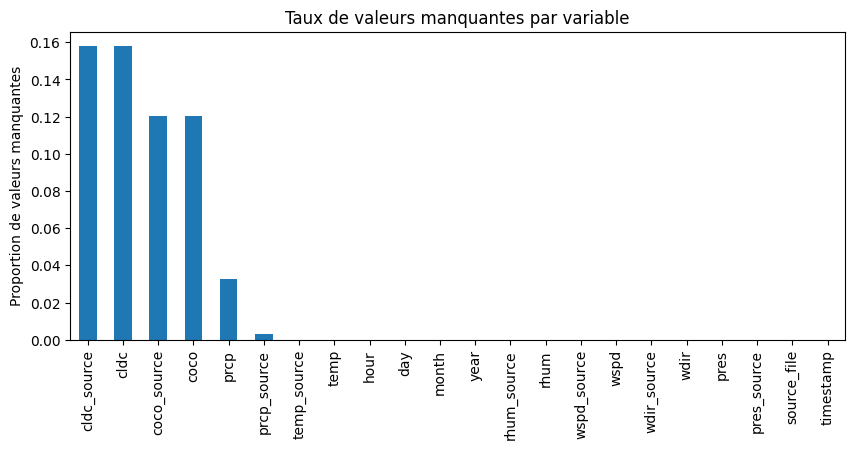

In [12]:
plt.figure(figsize=(10, 4))
missing_ratio.plot(kind="bar")
plt.title("Taux de valeurs manquantes par variable")
plt.ylabel("Proportion de valeurs manquantes")
plt.show()

### Analyse

L’analyse du taux de valeurs manquantes met en évidence plusieurs points importants :

- Les variables fondamentales pour l’analyse météo (température, humidité, pression, vent) sont **complètement renseignées** sur l’ensemble de la période 2022–2025.
- Les précipitations (`prcp`) présentent un faible taux de valeurs manquantes (~3,25 %), ce qui est courant pour ce type de variable.
- Les variables liées à la couverture nuageuse (`cldc`) et aux conditions météorologiques synthétiques (`coco`) présentent des taux de valeurs manquantes plus élevés (environ 12 % à 16 %).

Ces valeurs manquantes concernent principalement des variables **dérivées ou qualitatives**, dont l’impact direct sur la prédiction du temps au tour est secondaire par rapport aux variables physiques continues.

### Impact potentiel sur la prédiction du temps au tour

Du point de vue métier :

- La température, la pression, l’humidité et le vent sont des facteurs directement liés à l’aérodynamique, à l’adhérence et au comportement des pneumatiques.
- Les variables `cldc` et `coco` apportent un contexte atmosphérique global, mais leur absence ponctuelle n’empêche pas l’exploitation du jeu de données.
- Les précipitations restent exploitables malgré quelques valeurs manquantes, notamment via des stratégies d’imputation ou de transformation ultérieures.

Ainsi, la qualité globale des données météo est jugée **suffisante et cohérente** avec l’objectif du projet.

---------------

## Hétérogénéité des sources de données

Les colonnes suffixées par `_source` indiquent l’origine des mesures pour chaque variable (station réelle, réanalyse, prévision) :

| _source           | Nature de la donnée        | Origine principale                     | Observation réelle | Niveau de fiabilité | Usage recommandé en ML |
|------------------|----------------------------|----------------------------------------|--------------------|---------------------|------------------------|
| isd_lite         | Mesure station             | NOAA – Integrated Surface Database     | Oui                | Très élevé          | Vérité terrain (prioritaire) |
| synop            | Mesure station officielle  | Réseau WMO (Météo France, DWD, etc.)   | Oui                | Très élevé          | Vérité terrain (prioritaire) |
| metno_forecast   | Donnée de substitution     | MET Norway (modèle de prévision)       | Non                | Moyen               | À flagger, usage secondaire |
| ecmwf            | Modèle global / réanalyse  | ECMWF                                  | Non                | Bon                 | Acceptable avec prudence |
| era5             | Réanalyse atmosphérique    | ECMWF ERA5                             | Non                | Bon à très bon      | Séries continues / backtesting |
| era5_land        | Réanalyse terrestre        | ECMWF ERA5-Land                        | Non                | Bon à très bon      | Complément homogène |
| model            | Modèle générique           | Divers modèles                         | Non                | Moyen               | À utiliser avec prudence |


La présence de sources multiples implique :
- une hétérogénéité potentielle de précision,
- des différences de disponibilité selon les périodes,
- une variabilité normale dans des données agrégées à grande échelle.

Certaines sources de données proviennent de modèles de prévisions, et seront peut-être moins fiables que d'autres.

Ces informations seront conservées en Bronze et pourront être exploitées ou agrégées ultérieurement si nécessaire.

In [13]:
df_meteo["temp_source"].value_counts(dropna=False)

temp_source
isd_lite          25984
metno_forecast     8945
Name: count, dtype: int64

In [14]:
df_meteo["pres_source"].value_counts(dropna=False)

pres_source
isd_lite          25984
metno_forecast     8945
Name: count, dtype: int64

In [16]:
df_meteo["prcp_source"].value_counts(dropna=False)

prcp_source
metno_forecast    17488
isd_lite          17328
NaN                 113
Name: count, dtype: int64

→ *Nous pouvons voir que pour les données concernant les précipitations, environ la moitié proviennent d'un modèle de prévision et sont des données de substitution.*

-------------------

### Conclusion sur la qualité des données météo

Les données météorologiques collectées pour la période 2022–2025 présentent :

- une **excellente complétude** des variables physiques critiques,
- des valeurs manquantes concentrées sur des variables secondaires,
- une structure compatible avec une exploitation en machine learning.

Ces constats confirment la pertinence de la source Meteostat pour une utilisation dans un cadre de prédiction du temps au tour en Formule 1.

-----------------

## Décision concernant le nettoyage des données

Conformément aux principes de l’architecture data du projet :

- aucune correction,
- aucune interpolation,
- aucun filtrage

n’est appliqué aux données météo dans la couche Bronze.

Les données sont conservées **telles que fournies par la source**, afin de garantir la traçabilité et la reproductibilité.

Les traitements liés à la qualité des données seront réalisés dans les couches Silver et Gold, en fonction des besoins du modèle.

----------

## Analyse métier : rôle des variables météo dans la prédiction du temps au tour

### Objectif de l'analyse

Cette section vise à analyser le rôle des principales variables météorologiques dans la performance d’un tour de Formule 1.

L’objectif n’est pas encore de construire un modèle, mais de comprendre :
- quelles variables météo ont un impact direct ou indirect sur le temps au tour,
- pourquoi ces variables sont pertinentes d’un point de vue physique et sportif,
- comment elles pourront être exploitées ultérieurement en machine learning.


### Température de l'air (*temp*)

La température de l’air est une variable clé en Formule 1 pour plusieurs raisons :

- Elle influence directement la densité de l’air, et donc l’efficacité aérodynamique.
- Elle impacte le refroidissement du moteur, des freins et des pneumatiques.
- Elle conditionne la vitesse de mise en température et la fenêtre d’exploitation optimale des pneus.

Une température trop basse ou trop élevée peut entraîner une perte d’adhérence, une dégradation prématurée des pneus ou une baisse de performance globale.

La variable `temp` est donc considérée comme **fondamentale** pour la prédiction du temps au tour.

### Humidité relative (*rhum*)

L’humidité relative joue un rôle indirect mais non négligeable :

- Elle modifie la densité de l’air et donc l’appui aérodynamique.
- Elle peut affecter la sensation de grip, notamment sur certaines pistes.
- Elle est souvent corrélée à d’autres phénomènes météo (pluie, nuages, variations thermiques).

Bien que son impact soit moins direct que la température, l’humidité apporte un contexte atmosphérique utile pour affiner la prédiction.

### Pression atmosphérique (*pres*)

La pression atmosphérique influence directement la densité de l’air :

- Une pression élevée correspond généralement à un air plus dense, augmentant l’appui aérodynamique mais aussi la traînée.
- Une pression plus basse peut réduire l’appui et modifier le comportement de la monoplace.

Cette variable est particulièrement pertinente sur des circuits situés en altitude ou soumis à de fortes variations météorologiques.

### Direction du vent (*wdir*) et vitesse (*wspd*)

Le vent est une variable complexe mais déterminante :

- La vitesse du vent influence la stabilité de la monoplace, notamment en ligne droite et dans les zones de freinage.
- La direction du vent peut modifier l’équilibre aérodynamique selon l’orientation du circuit.
- Des rafales ou vents latéraux peuvent provoquer des pertes d’adhérence ponctuelles.

Ces effets ne sont pas toujours linéaires, mais ils justifient pleinement l’intégration du vent dans un modèle prédictif.

### Variables contextuelles (*cldc*, *coco*)

Les variables de couverture nuageuse (`cldc`) et de conditions météorologiques synthétiques (`coco`) fournissent un contexte global :

- Elles permettent de caractériser des situations météo complexes.
- Elles peuvent servir de variables secondaires ou de support à l’ingénierie de features.
- Leur absence ponctuelle est acceptable compte tenu de leur rôle complémentaire.

Ces variables ne sont pas critiques individuellement, mais enrichissent la compréhension globale des conditions de piste.

### Synthèse métier

Les variables météorologiques retenues couvrent l’ensemble des facteurs environnementaux influençant la performance en Formule 1 :

- variables physiques directes (température, pression, vent),
- variables d’adhérence et de sécurité (précipitations),
- variables de contexte atmosphérique (humidité, nuages).

Cette analyse confirme la pertinence des données météo comme composant central du futur modèle de prédiction du temps au tour.

-------------

## Lien avec les données circuits

Les données météorologiques issues de Meteostat sont intrinsèquement liées à une localisation géographique précise
(latitude / longitude ou station météo).

Or, l’objectif final du projet est de prédire le temps au tour sur des circuits de Formule 1.
Il est donc nécessaire d’établir un lien clair entre :
- un circuit F1,
- une position géographique,
- une source de données météo pertinente.

Afin de garantir la clarté, la traçabilité et la justification des décisions, le projet sépare volontairement :
- l’exploration des données météo (notebook 02),
- l’identification et la géolocalisation des circuits (notebook 03).

Cette séparation permet :
- d’éviter toute dépendance implicite entre sources,
- de documenter indépendamment les limites et hypothèses de chaque jeu de données,
- de conserver une architecture pédagogique et défendable.

Dans l’architecture F1PA, Meteostat joue le rôle de source météo générique et indépendante :
- les fichiers sont récupérés sans connaissance préalable des circuits,
- aucune sélection géographique fine n’est encore appliquée,
- les données sont stockées telles quelles en Bronze.

### Hypothèse métier

À ce stade du projet, l’hypothèse suivante est posée :

Les variables météorologiques pertinentes pour la prédiction du temps au tour
sont indépendantes du circuit lors de leur exploration initiale.

Autrement dit :
- la structure des données,
- la granularité temporelle,
- la qualité des mesures,
- la disponibilité des variables

peuvent être validées sur une localisation générique.

------------------

### Rôle du notebook 03 - Wikipedia circuits

Le notebook 03 aura pour objectif de :
- recenser l’ensemble des circuits de Formule 1 sur la période étudiée,
- extraire leurs coordonnées géographiques (latitude, longitude),
- fournir une table de référence circuits → localisation.

Cette table permettra ultérieurement :
- de sélectionner les stations météo les plus proches,
- de filtrer les données Meteostat pertinentes par circuit,
- de construire des features météo contextualisées.

---------

## La couche Bronze pour Meteostat

En conséquence, la couche Bronze pour Meteostat respecte les principes suivants :
- données stockées par fichier source (ex. ville / station),
- aucune jointure avec OpenF1 ou circuits,
- aucune agrégation ou interpolation,
- horodatage explicite conservé.

La responsabilité de l’alignement météo ↔ circuit est volontairement reportée
aux couches Silver et Gold.

Les données météorologiques sont stockées au format CSV, tel que fourni par Meteostat.

Ce choix est motivé par :
- la simplicité du format,
- la lisibilité pour l’exploration et l’audit,
- la compatibilité native avec Python / pandas,
- la traçabilité directe avec la source.

### Organisation des fichiers

Les fichiers Meteostat sont stockés dans le dossier `data\bronze\meteostat\hourly\`.  
Chaque fichier correspond à :
- une localisation (ville / station),
- une année civile,
- une granularité horaire.

### Schéma conservé

Les colonnes suivantes sont conservées sans modification :

- year, month, day, hour
- timestamp (reconstruit à partir des composantes)
- temp, rhum, pres
- wspd, wdir
- prcp
- cldc, coco
- *_source (métadonnées de provenance)  

La présence des colonnes *_source permet de conserver une information précieuse
sur l’origine et la fiabilité des mesures.

### Valeurs manquantes

Aucune imputation, suppression ou interpolation n’est réalisée en couche Bronze.

Les valeurs manquantes sont conservées telles quelles afin de :
- préserver l’intégrité des données originales,
- permettre des choix d’imputation contextualisés ultérieurement,
- documenter les limites réelles de la source.

### Granularité temporelle

Les données sont conservées à la granularité horaire native de Meteostat.

Cette granularité est cohérente avec :
- la disponibilité des données météo,
- la fréquence de variation des phénomènes météorologiques,
- la future agrégation ou interpolation vers le niveau du tour (lap-level).

### Exclu de la couche Bronze

Les opérations suivantes ne sont pas réalisées en Bronze :
- sélection des stations les plus proches des circuits,
- alignement temporel avec les tours OpenF1,
- agrégation sur les secteurs ou les sessions,
- création de features métier.

### Synthèse des décisions

Les décisions prises pour l’ingestion Meteostat en Bronze sont les suivantes :

- source : Meteostat (fichiers CSV)
- granularité : horaire
- période : 2022–2025
- transformations : aucune
- objectif : base météo brute, auditable et reproductible

---------------

## Conclusion du Notebook 02

Ce notebook a permis :
- de comprendre la structure des données Meteostat,
- d’identifier les variables météo pertinentes pour la prédiction du temps au tour,
- d’évaluer la qualité et la granularité des données,
- de définir clairement les règles d’ingestion en couche Bronze.

Les étapes suivantes consisteront à :
- identifier précisément les circuits de Formule 1 et leurs coordonnées (notebook 03),
- sélectionner les données météo pertinentes par circuit,
- aligner les données météo avec les tours OpenF1 en couche Silver.